In [1]:
import fnmatch, re, os
import json

def parametrizedFileSelection(fileDirectory, fileArguments):
    files = []
    
    for k,v in fileArgs.items():
        if type(v) is not list:
            fileArgs[k] = [v]
        
    for file in os.listdir(fileDirectory):
        if not os.path.isdir(fileDirectory+file):
            match = True
            for key in fileArguments:
                match = False
                for value in fileArguments[key]:
                    expression = key + "=" + str(value)
                    if expression + ',' in file or expression + '_' in file:
                        match = True
                if match == False:
                    break

            if match == True:
                files.append(file)
        
    return files


# Experiment factors
Communs
- filename
- nWorkers
------- order based ------------
- voterSeed
- nVoters
--------Community detection based----------
- comDet
- assignment
- withBoundary (false si order based)
--------- Other ----------
- distType (close/far)
- minDist 

Pour un même nombre de worker on fait varier la seed (cas order based)

In [3]:
import pandas as pd
import numpy as np

fileDirectory = "../outputs/"

# fileArgs = { "nWorkers": 10, "voterSeed": 0, "minDist": "1"}
fileArgs = {}      
files = parametrizedFileSelection(fileDirectory, fileArgs)

filesData = []

for file in files:
    with open(fileDirectory + file) as json_file:
        data = json.load(json_file)
        filesData.append(data)        
       # print(len(data['candidates'][0]) ,"-", len(data['candidates']), data['candidates'])
df = pd.DataFrame(filesData)

In [4]:
def boxPlotAndHist(data,plotData, imgPath=None):
    fig, ax = plt.subplots(ncols=2)
    ax[0].set_title(plotData["title"])
    ax[0].set_yscale('log')
    ax[0].boxplot(data)

    ax[1].set_title(plotData["title"])
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel(plotData["title"])
    
    upperBound=data.quantile(0.9)
    ax[1].hist(data, bins=np.arange(0,upperBound+2,1))
    if imgPath is not None:
        fig.savefig(imgPath)
    plt.close(fig)

In [5]:
import matplotlib.pyplot as plt

largestCliqueSize = lambda x : len(x[0])
largestCliqueCount = lambda x : len(x)


largestCliqueSizeData = df["candidates"].apply(largestCliqueSize)
largestCliqueCountData = df["candidates"].apply(largestCliqueCount)

plotData={"title":"CliqueSize"}

boxPlotAndHist(largestCliqueSizeData,plotData)

plotData={"title":"CliqueCount"}

boxPlotAndHist(largestCliqueCountData,plotData)

## Distribution du nombre de workers distants en fonction de la seed utilisée

In [6]:
def distDistrib(df,seedFilter,clusterDistKey,imgPath=None):
    otherWorkersDistance = lambda x : x[clusterDistKey]
    
    data = []
    for seed in seedFilter:
        filterOnSeed = df.where(df["voterSeed"] == seed).dropna()
        otherWorkersDistanceData = filterOnSeed.head(1)["workerDistances"].apply(otherWorkersDistance)
        if len(otherWorkersDistanceData)>0:
            data.append(otherWorkersDistanceData.tolist()[0]) 
    newData = np.zeros((len(seedFilter),10), dtype=int)

    for x,l in enumerate(data):
        for y in range(0,len(l)):
            newData[x][y] = l[y]
            
    df2 = pd.DataFrame(newData, columns=range(-1,9))

    df2 = df2.apply(lambda x : x//2) #remove bidirectionnal links

    fig1, ax1 = plt.subplots(nrows=5, ncols=2, figsize=(4*2,3*5))
    for index, column in enumerate(df2.columns):
        ax1[index//2][index%2].set_title('Distance = ' + str(column))
        ax1[index//2][index%2].hist(df2[column])
        ax1[index//2][index%2].set_yscale("log")
        
    if imgPath is not None:
        fig1.savefig(imgPath)
    #plt.close(fig1)

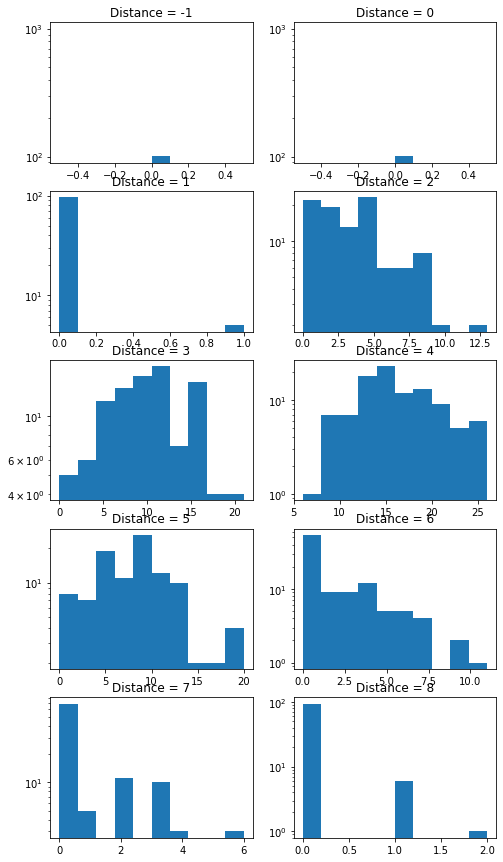

In [7]:
from scipy import stats
import numpy as np

seedFilter = ["NA",*list(range(0,100))]
#seedFilter = 
clusterDistKey="other"
distDistrib(df,seedFilter,clusterDistKey,imgPath=None)


Commentaire : pas de loi normale (pour l'instant) -> a tester avec les 100 seeds

## Evolution du nombre de workers dans les cliques maximales en fonction de la distance maximale entre workers

In [8]:
def formatToDict(df):
    candidatesByMinDist = {}
    for idx, row in df.iterrows():
        candidatesByMinDist[row["minDist"]] = row["candidates"]
    return candidatesByMinDist

In [155]:
df.head()
df = df[[
    'filename',
    'nWorkers',
    'voterSeed',
    'comDet',
    'assignment',
    'withBoundary',
    'distType',
    'candidates',
    'minDist'
]]
#print(df)
cols = df.columns[:-2].tolist()
conditions=[df["voterSeed"].isin(["NA"])\
            & df["withBoundary"].isin([True])\
            & df["assignment"].isin(["sizeProRataWorkerAssignement"])\
            & df["comDet"].isin(["community_label_propagation"])\
            & df["nWorkers"].isin([10,16,43,70,114,186,304,495])\
            ,
            df["voterSeed"].isin(["NA"])\
            & df["withBoundary"].isin([True])\
            & df["assignment"].isin(["sizeOrderedRoundRobinWorkerAssignement"])\
            & df["comDet"].isin(["community_multilevel"])\
            & df["nWorkers"].isin([10,16,43,70,114,186,304,495])\
            ,
            #df["voterSeed"].isin(["NA"])\
            #& df["withBoundary"].isin([True])\
            #& df["assignment"].isin(["diameterProRataWorkerAssignement"])\
            #& df["comDet"].isin(["community_multilevel"])\
            ##& df["nWorkers"].isin([10,16,43,70,114,186,304,495,807])\
            #,
            #df["voterSeed"].isin(["NA"])\
            #& df["withBoundary"].isin([True])\
            #& df["assignment"].isin(["diameterWorkerAssignment"])\
            #& df["comDet"].isin(["community_multilevel"])\
            ##& df["nWorkers"].isin([10,16,43,70,114,186,304,495,807])\
            #,
            df["voterSeed"].isin(["NA"])\
            & df["withBoundary"].isin([True])\
            & df["assignment"].isin(["nodeEdgeRatioProRataWorkerAssignement"])\
            & df["comDet"].isin(["community_multilevel"])\
            & df["nWorkers"].isin([10,16,43,70,114,186,304,495])\
            ,
            df["voterSeed"].isin(["NA"])\
            & df["withBoundary"].isin([True])\
            & df["assignment"].isin(["nodeDensityRatioProRataWorkerAssignement"])\
            & df["comDet"].isin(["community_multilevel"])\
            & df["nWorkers"].isin([10,16,43,70,114,186,304,495])\
            #,
            #~df["voterSeed"].isin(["NA"])\
            #& df["nWorkers"].isin([10,16,43,70,114,186,304,495,807])\
            #& df["assignment"].isin(["generateArrangementNumber"])
           ]
cliqueSizes=[]
for condition in conditions:
    groupDf = df.where(condition).dropna().groupby(by=cols)[['candidates', 'minDist']].apply(formatToDict)
    cliqueNumber = [ { k:len(v) for k,v in element.items() } for element in groupDf ]
    cliqueSize = [ { k:len(v[0]) for k,v in element.items() } for element in groupDf ]
    cliqueSizes.append(cliqueSize)
#print(cliqueSizes)

for index, row in enumerate(groupDf):
    fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize=(4,3))
    fig.suptitle("Clique number by minDist", fontsize=18)
    ax.plot(cliqueNumber[index].keys(), cliqueNumber[index].values())
    ax.set_title(',\n'.join(str(groupDf.keys()[index]).split(', ')))

for index, row in enumerate(groupDf):
    fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize=(4,3))
    fig.suptitle("Clique size by minDist", fontsize=18)
    ax.plot(cliqueNumber[index].keys(), cliqueSize[index].values())
    ax.set_title(',\n'.join(str(groupDf.keys()[index]).split(', ')))

## Determination d'un k tq à 95% il n'y ait pas de worker colusion

In [156]:
def workerThreshold(cliqueSize, minDist, threshold, plotData, imgPath = None):

    maxCliqueSize = max([max(cs) for cs in cliqueSize])
    minCliqueSize = min([min(cs) for cs in cliqueSize])
    
    fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
    
    
    ##todo faire apparaitre le nb de workers considéré (ici 807)
    fig1.suptitle(plotData["suptitle"], fontsize=18)

    bins=np.arange(minCliqueSize,maxCliqueSize+2, step=1)

    ax1[0].hist(cliqueSize, bins=bins)
    ax1[0].grid(linestyle=':')
    ax1[0].set_yscale("log")
    bar_heights_list, _, _ = ax1[1].hist(cliqueSize, cumulative=True, density=True, bins = bins, histtype="step", label=[
                                "sizeProRata",
                                "sizeOrderedRoundRobin",
                                #"diameterProRata",
                                #"diameter",
                                "nodeEdgeRatioProRata",
                                "nodeDensityRatioProRata"
        ])
    xThresholds=[]
    for bar_heights in bar_heights_list:
        xThreshold = 0
        for index, v in enumerate(bar_heights):
            if v >= threshold:
                xThreshold = bins[index]
                break
        #ax1[1].axhline(threshold, color='r', linestyle='dashed', linewidth=1)
        #ax1[1].axvline(xThreshold, color='r', linestyle='dashed', linewidth=1)
        
        #ax1[1].text(xThreshold + 0.7, 0.025, xThreshold).set_color('red')
        #ax1[1].plot(xThreshold,threshold, marker='x')
        #ax1[1].annotate(xThreshold, xy=(xThreshold,threshold), textcoords='data')
        ax1[1].legend(loc='lower right')
        xThresholds.append(xThreshold)
        
    #ax1[1].text(minCliqueSize, threshold + 0.02 , threshold).set_color('red')
    
    ax1[1].set_title(plotData["title"])
    ax1[1].grid(linestyle=':')
    if imgPath is not None:
        fig1.savefig(imgPath)
            
    return xThresholds


[4, 18, 18, 2]
[121, 118, 90, 140]
[212, 186, 162, 154]


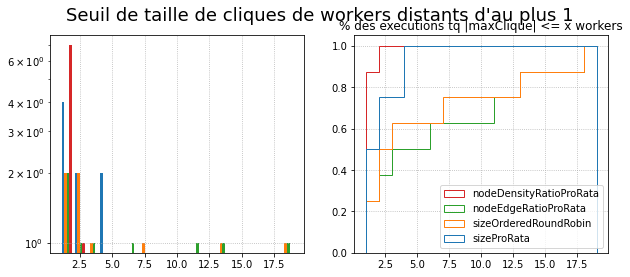

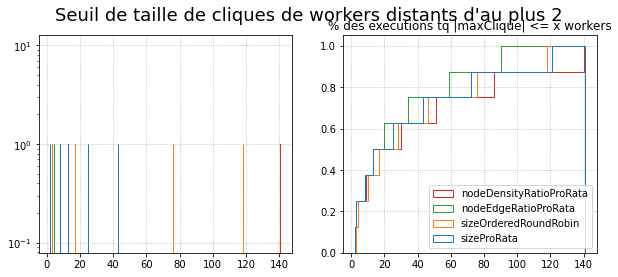

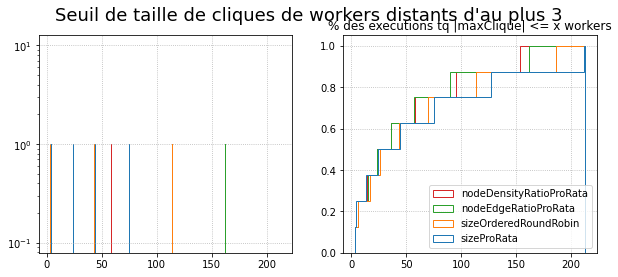

In [157]:
threshold=0.95
for minDist in range(1,4):
    cliqueSizeByMinDist = [[ element.get(minDist) for element in cliqueSize if element.get(minDist) is not None]
                              for cliqueSize in cliqueSizes]
    plotData={"suptitle":"Seuil de taille de cliques de workers distants d'au plus {}".format(minDist),
             "title":"% des executions tq |maxClique| <= x workers".format(minDist, threshold),
             }
    thresholds=workerThreshold(cliqueSizeByMinDist, minDist, threshold,plotData)
    print(thresholds)

Pour que 95% des executions n'aient pas de collusion il faut un nombre de workers t (sur n workers) min de xThreshold pour une minDist donnée 

Ici pour un distance maximale interworkers de 3 on a 95% des executions dont la clique maximale comprend 390 workers sur 807
Ainsi si on considère qu'une clique est potentiellement malveillante avec des workers de distance maximale de 3 il faudra prendre au moins 390 workers parmis les 807

Trouver la racine positive du polynome x² + x - nWorkers pour trouver la borne maximale de workers malveillants

Le seuil de workers malveillants est de 27 sur un total de 807 workers et de + de 4000 votants
Ce nombre respecte la contrainte du (n-t²) workers inactifs

Note par rapport aux résultats sur la détéction de communauté vs Order based : Des résultats en seuils assez similaire, cependant on observe pour la partie CD une hausse beaucoup plus linéaire du % par rapport au nb de noeuds dans la clique 

In [38]:
import numpy.polynomial.polynomial as nppol
def maxTbyParticipantsCount(maxParticipants, interestValues,figax=(None,None), imgPath=None):
    assert all([i <=maxParticipants for i in interestValues])
    fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(12,9))
    racPosMaxT=lambda x:int(nppol.polyroots([-x-1, 1, 1])[1])
    maxTs=[racPosMaxT(x) for x in range(maxParticipants+1)]
    
    ax.plot(range(maxParticipants+1),maxTs)
    ax.set_xlabel("n voters in graph")
    ax.set_ylabel("Maximum t value to satisfy n,t,m constraints")
    ax.grid(linestyle=':')
    
    for value in interestValues:
        maxT=maxTs[value]
        ax.plot(value,maxT, marker='x', label="()")
        ax.annotate('(%s, %s)' % (value,maxT), xy=(value,maxT), textcoords='data')
    if imgPath is not None:
        fig.savefig(imgPath)
    #plt.close(fig)

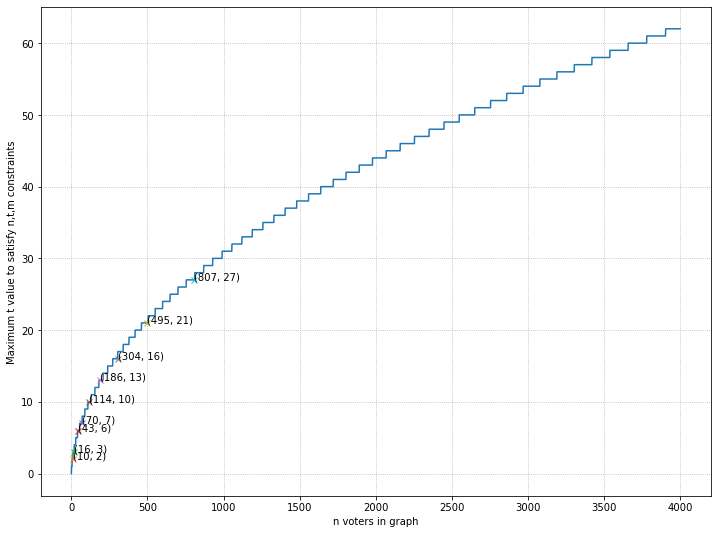

In [39]:
maxTbyParticipantsCount(4000,[10,16,43,70,114,186,304,495,807])